<h1 style="color:red";> Our research question</h1>

<p>How many citations (according to <a href="http://opencitations.net/download#coci"><b>COCI</b></a>) involve, either as citing or cited entities, publications in SSH journals (according to <a href="https://kanalregister.hkdir.no/publiseringskanaler/erihplus/periodical/listApproved"><b>ERIH-PLUS</b></a>) included in <b>OpenCitations Meta</b>? What are the disciplines that cites the most and those cited the most? How many citations start from and go to publications in OpenCitations Meta that are not included in SSH journals?</p>


<h2 style="color:red;">27/03</h2>

<p>Today I started thinking about the abstract and first of all I have read <a href="https://www.emeraldgrouppublishing.com/how-to/authoring-editing-reviewing/write-article-abstract#structured-abstract">the guideline</a> proposed by Emerald Publishing to sketch it.</p>
<p><b>Maximum amout of words</b>: "most journal author guidelines set a maximum of 250 words, including keywords and article classification".</p>

<p>In order to try to figure out the methodology to follow to answer to our rearch question, I thought it could have been useful to start exploring the <b>structure of the data</b>. I've downloaded the list of approved journals in ERIH-PLUS in the csv format and also one archive of COCI's dump.</p>

<h4>ERIH PLUS data</h4>

In [1]:
import pandas as pd
df_ErihPlus = pd.read_csv("2023-03-27 ERIH PLUS approved journals and series.csv", sep=";")

In [2]:
df_ErihPlus.columns

Index(['Journal ID', 'Print ISSN', 'Online ISSN', 'Original Title',
       'International Title', 'Country of Publication',
       'ERIH PLUS Disciplines', 'OECD Classifications', '[Last Updated]'],
      dtype='object')

In [4]:
df_ErihPlus.dtypes
df_ErihPlus['Print ISSN'].isnull().sum()

2325

<h4>COCI data</h4>

In [4]:
import zipfile
from os.path import exists, makedirs

def extract_file(input_dir, output_dir):
    if not output_dir:
            if not exists(output_dir):
                makedirs(output_dir)
    with zipfile.ZipFile(input_dir, 'r') as zip_ref:
        zip_ref.extractall(output_dir)    

In [5]:
extract_file("2022-12-31T201913_0-19_1.zip", "COCI_data")

<p>In each csv there are 7 columns: oci, citing (doi), cited (doi), creation (date), timespan, journal_sc (yes or no), author_sc(yes or no). The two columns provide the information to know if the citing and cited entities share at least one author and if they have been published in the same journal.</p>
<p>OCI is the OpenCitation identifier for the citation.</p>

<h2 style="color:red;">28/03</h2>

<h4>Abstract</h4>

<p>Today we met to write the abstract. The following is the first version of it:</p>
<p>Purpose: we want to find out
    <ol>
    <li>by looking at citations data contained in COCI, the number of citations included in Meta which refer to publication in SSH (Social Sciences and Humanities) journals indicated in ERIH-PLUS</li>
    <li>the disciplines citing the most VS the disciplines cited the most</li>
    <li>the citations from/to publication contained in Meta which are not included in SSH journals</li> 
    </ol>
We want to create a connection between these three different datasets for having an overall view of the citations present in each of them.</p>
<p>
Methodology: we approach the problem from a computational point of view, by building a python software able to analyse the data, querying them in order to retrieve the info needed and to present the results in a clear and understandable way.</p>
<p>
Findings: for what concerns the findings, we can see that there are no meaningful differences in the number of citations coming from different disciplines, since it is related to the subject of the study, while the ones cited the most belong to psychology, health and science studies.</p>
<p>
Originality/Value: the research conducted by us can be defined as very valuable, since it adds information to existing resources with the aim of facilitating their use and allowing the users to have a clearer view of the data contained in each dataset. Further development can be made, for example analysing other disciplines, to have the same overview as the one created by us but related to other fields.</p>

<p>Keywords: OpenScience, Citation, OC-COCI, OC-Meta, ERIH-PLUS, journals</p>

<h4>Data analysis</h4>

<p>I went on analysing the data we'll have to handle for the project, in particular, after having downloaded the META dump, I tried to figure the csv columns to use to create a connection between the three different datasets in order to answer to the research question.</p>

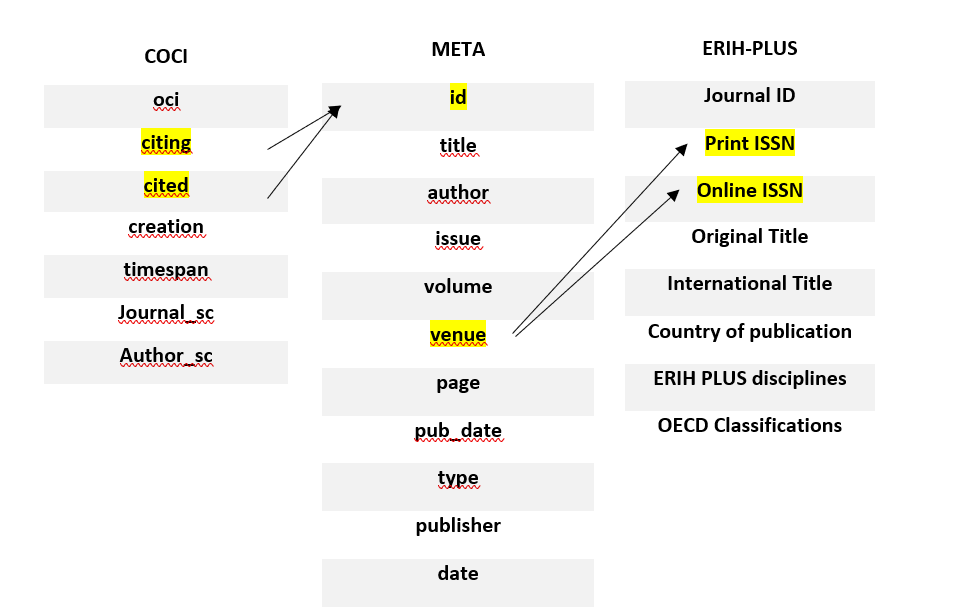

<p>COCI is the index of Crossref open DOI-to-DOI citations, and from the OpenCitation website we can read that COCI does not index Crossref references that are not open, nor Crossref open references to entities that lack DOIs. </p>

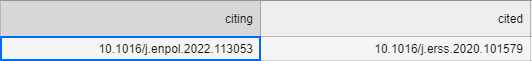

<p>Every entity in OpenCitations Meta is assigned persistent internal identifier called OpenCitations Meta Identifier (OMID).</p>

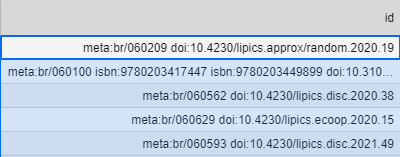

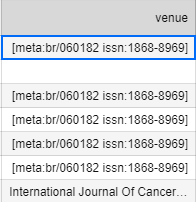

In [4]:
import pandas as pd
Meta_csv = pd.read_csv("0.csv", sep=",")

In [6]:
Meta_csv.dtypes

id            object
title         object
author        object
issue         object
volume       float64
venue         object
page          object
pub_date      object
type          object
publisher     object
editor        object
dtype: object

<p>So in order to connect Meta and the ERIH PLUS csv we have to take into account the ISSN</p>

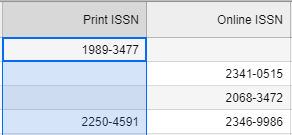

<h2 style="color:red;">05/04</h2>

<p>I've tried to figure out a way to preprocess our datasources in order to keep only the csv columns useful for answering to our research question. In particular I've tried to preprocess a part of the meta csv dump, keeping just the columns "id" and "venue" and removing the identifiers that are not "doi" and "issn".</p>
<p> I've used the method "get_all_files" of the opencitations preprocess package in order to retrieve all the files from the original dump. This method takes in input a path and the string of a file extension (e.g.: "directory_where_the_data_are_stored/datasource_dump.zip", ".json"), and  returns a list of all the files with the required extension found in the data dump (either a directory or a compressed archive), and a "tar.gz" opener if needed, otherwise None (if the dump is not tar.gz compressed it is not needed). Of course this method can be refined for the purpose of our research, according to the structure of the dumps we have to deal with.</p>

In [ ]:
import os
import pathlib
import tarfile
import zipfile
from abc import ABCMeta, abstractmethod
from os import walk, sep
from os.path import isdir, basename, exists
import zstandard as zstd


class Preprocessing(metaclass=ABCMeta):
    """This is the interface for implementing preprocessors for specific datasources.
    It provides the signatures of the methods for preprocessing a dump"""

    def __init__(self, **params):
        """preprocessor constructor."""
        for key in params:
            setattr(self, key, params[key])

    def get_all_files(self, i_dir_or_compr, req_type):
        result = []
        targz_fd = None

        if isdir(i_dir_or_compr):

            for cur_dir, cur_subdir, cur_files in walk(i_dir_or_compr):
                for cur_file in cur_files:
                    if cur_file.endswith(req_type) and not basename(cur_file).startswith("."):
                        result.append(os.path.join(cur_dir, cur_file))
        elif i_dir_or_compr.endswith("tar.gz"):
            targz_fd = tarfile.open(i_dir_or_compr, "r:gz", encoding="utf-8")
            for cur_file in targz_fd:
                if cur_file.name.endswith(req_type) and not basename(cur_file.name).startswith("."):
                    result.append(cur_file)
        elif i_dir_or_compr.endswith("zip"):
            with zipfile.ZipFile(i_dir_or_compr, 'r') as zip_ref:
                dest_dir = i_dir_or_compr.split(".")[0] + "decompr_zip_dir"
                if not exists(dest_dir):
                    os.makedirs(dest_dir)
                zip_ref.extractall(dest_dir)
            for cur_dir, cur_subdir, cur_files in walk(dest_dir):
                for cur_file in cur_files:
                    if cur_file.endswith(req_type) and not basename(cur_file).startswith("."):
                        result.append(cur_dir + sep + cur_file)

        elif i_dir_or_compr.endswith("zst"):
            input_file = pathlib.Path(i_dir_or_compr)
            dest_dir = i_dir_or_compr.split(".")[0] + "_decompr_zst_dir"
            with open(input_file, 'rb') as compressed:
                decomp = zstd.ZstdDecompressor()
                if not exists(dest_dir):
                    os.makedirs(dest_dir)
                output_path = pathlib.Path(dest_dir) / input_file.stem
                if not exists(output_path):
                    with open(output_path, 'wb') as destination:
                        decomp.copy_stream(compressed, destination)
            for cur_dir, cur_subdir, cur_files in walk(dest_dir):
                for cur_file in cur_files:
                    if cur_file.endswith(req_type) and not basename(cur_file).startswith("."):
                        result.append(cur_dir + sep + cur_file)
        elif i_dir_or_compr.endswith(".tar"):
            dest_dir = i_dir_or_compr.split(".")[0] + "_open_tar_dir"
            with tarfile.open(i_dir_or_compr, "r") as tf:
                tf.extractall(path=dest_dir)
            for cur_dir, cur_subdir, cur_files in walk(dest_dir):
                for cur_file in cur_files:
                    if cur_file.endswith(req_type) and not basename(cur_file).startswith("."):
                        result.append(cur_dir + sep + cur_file)
        else:
            print("It is not possible to process the input path.", i_dir_or_compr)
        return result, targz_fd


    @abstractmethod
    def split_input(self):
        """ ...
        """
        pass

    @abstractmethod
    def splitted_to_file(self, cur_n, data, type):
        pass

<p>I've created the class MetaPreProcessing as a subclass of the class Preprocessing, with two methods "splitted_to_file" and "split_input". 
"Splitted_to_file" writes in the output folder a new csv file every n preprocessed entities which passed the preprocessor filter, where n is the integer number defined as an input parameter. In particular, the method takes in input the current number of entities that successfully passed the preprocessor filter, a data structure containing the preprocessed entities to store in the output file (csv in this case), and the string of the file extension.
"Split_input" is the main method of the class and is in charge of iterating over the input files, creating preprocessed version of those by removing columns and by removing identifiers different from "doi" and "issn".</p>

In [ ]:
import csv
from datetime import datetime
import json
import os
from os import makedirs
from os.path import exists
from tqdm import tqdm
import pandas as pd
from re import sub, match

from preprocess.base import Preprocessing


class MetaPreProcessing(Preprocessing):
    _req_type = ".csv"
    _accepted_ids = "doi"
    _accepted_ids_venue = "issn"
    _entity_columns_to_discard = ["title", "author", "issue", "volume", "page", "pub_date", "type", "publisher", "editor"]
    _entity_columns_to_update = ["id", "venue"]

    def __init__(self, input_dir, output_dir, interval):
        self._input_dir = input_dir
        self._output_dir = output_dir
        if not exists(self._output_dir):
            makedirs(self._output_dir)
        self._interval = interval
        super(MetaPreProcessing, self).__init__()

    def splitted_to_file(self, cur_n, lines, type=None):
        if int(cur_n) != 0 and int(cur_n) % int(self._interval) == 0:
            filename = "filtered_" + str(cur_n // self._interval) + self._req_type
            if exists(os.path.join(self._output_dir, filename)):
                cur_datetime = datetime.now()
                dt_string = cur_datetime.strftime("%d%m%Y_%H%M%S")
                filename = filename[:-len(self._req_type)] + "_" + dt_string + self._req_type
            with open(os.path.join(self._output_dir, filename), "w", encoding="utf8", newline="") as f_out:
                keys = self._entity_columns_to_update
                dict_writer = csv.DictWriter(f_out, delimiter=",", quoting=csv.QUOTE_ALL, escapechar="\\",
                                             fieldnames=keys)
                dict_writer.writeheader()
                dict_writer.writerows(lines)
            lines = []
            return lines
        else:
            return lines

    def split_input(self):
        # an empty list to store the filtered entities to be saved in the output files is created
        lines = []
        count = 0
        # iterate over the input data
        all_files, targz_fd = self.get_all_files(self._input_dir, self._req_type)
        for file_idx, file in enumerate(tqdm(all_files), 1):
            chunksize = 100000
            with pd.read_csv(file, usecols=["id", "venue"], chunksize=chunksize, sep=",") as reader:
                for chunk in reader:
                    chunk.fillna("", inplace=True)
                    df_dict_list = chunk.to_dict("records")
                    for line in df_dict_list:
                        count += 1
                        ids_list = line.get("id").split(" ")
                        new_doi_key = ""
                        for id in ids_list:
                            # remove identifiers != doi
                            if match("^doi:10\.(\d{4,9}|[^\s/]+(\.[^\s/]+)*)/[^\s]+$", id):
                                new_doi_key += id + " "
                        line["id"] = sub("\s$", "", new_doi_key)
                        if line.get("venue"):
                            venue_ids_list = line.get("venue")
                            venue_ids_list = sub("\[", "", line.get("venue"))
                            venue_ids_list = sub("\]", "", line.get("venue"))
                            venue_ids_list = venue_ids_list.split(" ")
                            new_issn_key = ""
                            for venue_id in venue_ids_list:
                                # remove identifier != issn
                                if match("^issn:[0-9]{4}-[0-9]{3}[0-9X]$", venue_id):
                                    new_issn_key += venue_id + " "
                            line["venue"] = sub("\s$", "", new_issn_key)
                        lines.append(line)
                        if int(count) != 0 and int(count) % int(self._interval) == 0:
                            lines = self.splitted_to_file(count, lines)
        if len(lines) > 0:
            count = count + (self._interval - (int(count) % int(self._interval)))
            self.splitted_to_file(count, lines)

<h2 style="color:red;">21/04</h2>

<p>We met in order to revise the DMP after our colleagues' suggestions. We had a doubt about the part "Reused data", in particular the question was if we are reusing data even if we are creating a new dataset (the answer is yes because for proding it we are reusing COCI, META and ERIH-PLUS list of available journals).</p>

<h2 style="color:red;">22/04</h2>

<p> This morning we have worked on the protocol, focusing on describing in detail the preprocessing part, the one that we actually started to implement </p>

<h2 style="color:red;">26/04</h2>

<p>Today we worked on the code, and in particular on the preprocessing of COCI. The preprocessing has the duty to remove all the columns from the original dataset, apart from "citing" and "cited". The dump is huge and we can test it for the entire dump just using Olga's and Lorenzo's computers, both for the speed and for the available memory space.</p>

<h2 style ="color:red;">10/05</h2>
<p><b>Mea culpa</b>, during the last two weeks I completely forgot to update my diary. Anyway, now I will talk about the decisions we took until now and the steps we made in the development of the software.</p>
<p>In the previous update I have said that we could use just Olga's and Lorenzo's computers to test the COCI preprocessing, but it is false because now I have a SSD so also my computer has been used for launching the scripts.</p>
<p>The first task that we have addressed is the preprocessing of the data. After having developed the COCI's and META's preprocessing, both as subclasses of the main class Preprocessing, we have created the class ErihPreProcessing, simpler than the other two due to the different size of the dataset (erih is just 2,67MB). This class must be initialized with two parameters: the path of the ERIH csv and the path of the folder where you want to store the preprocessed version. The methods are: "preprocess_ERIH_plus" and "write_csv". The first is responsible for iterating the rows of the original csv, storing for each row the venue and the disciplines' information in one dictionary and append all the dictionaries created through the rows' iteration in a list, "ERIH_preprocessed". The list that is returned as output of the method "preprocess_ERIH_plus" is then used in the method "write_csv" for creating in the output folder a new csv having just two columns, "venue_id" and "ERIH_disciplines".</p>
<p>The logic behind the preprocessing of erih is to create a dataset compatible with Meta, in order to create a unified dataset. In Meta there isn't the distiction between "print ISSN" and "online ISSN", that is instead present in ERIH, and for this reason we decided to create a new CSV in which, in the case in ERIH we find both online ISSN and print ISSN, the two issn are separated in two different rows and the discipline associated to them is repeated.</p>

In [ ]:
import csv
import os
from os import makedirs
from os.path import exists

class ErihPreProcessing():
    def __init__(self, input_file_path, output_dir):
        self._input_file_path = input_file_path
        self._output_dir = output_dir
        if not exists(self._output_dir):
            makedirs(self._output_dir)
        super(ErihPreProcessing, self).__init__()

    def preprocess_ERIH_plus(self):
        ERIH_preprocessed = list()
        with open(self._input_file_path, newline='', encoding="utf-8") as csvfile:
            next(csvfile)
            reader = csv.reader(csvfile, delimiter=';')
            for row in reader:
                venue_dict = dict()
                venue_dict2 = dict()
                # venue_id
                if row[1] and row[2]:
                    issn1 = 'issn:' + str(row[1])
                    issn2 = 'issn:' + str(row[2])
                    venue_dict["venue_id"] = str(issn1)
                    venue_dict2["venue_id"] = str(issn2)
                elif row[1]:
                    venue_dict["venue_id"] = 'issn:' + str(row[1])
                elif row[2]:
                    venue_dict["venue_id"] = 'issn:' + str(row[2])
                # ERIH PLUS Disciplines
                if row[6]:
                    venue_dict["ERIH_disciplines"] = str(row[6])
                    venue_dict2["ERIH_disciplines"] = str(row[6])
                ERIH_preprocessed.append(venue_dict)
                if venue_dict2.get("venue_id"):
                    ERIH_preprocessed.append(venue_dict2)
        return ERIH_preprocessed

    def write_csv(self):
        filename = "erih_preprocessed.csv"
        with open(os.path.join(self._output_dir, filename), "w", encoding="utf8", newline="") as csv_output:
            writer = csv.writer(csv_output, delimiter=';')
            writer.writerow(['venue_id', 'ERIH_disciplines'])
            for dictionary in self.preprocess_ERIH_plus():
                writer.writerow(dictionary.values())
        csv_output.close()


<p>Now we have all the data preprocessed, and we have decided to work with two parallel methodology, one developed mainly by me and Olga and the other one by Lorenzo, in order to have the possibility to do a double check on the results obtained.</p>
<p>Before answering to the research questions, we had to create a unique dataset from meta_preprocessed and erih_preprocessed. We did it through the use of another class, ErihMeta, that uses another element coming from the OpenCitations repository, that is the class CSVManager, adapted to the structure of the ERIH_preprocessed dataset. In particular we have used the method "get_value" of the class CSVManager for retrieving the disciplines associated to a given ISSN. The dataset resulting from the union of ERIH_preprocessed and META_preprocessed is composed by all the META's columns ("id", "title", "author", "issue", "volume", "venue", "page", "pub_date", "type", "publisher", "editor") plus the column "erih_disciplines", populated with the information retrieved from erih_preprocessed.</p>
<p>The class ErihMeta is initialized with 4 parameters, the path of the meta_preprocessed dataset, the path of the erih_preprocessed dataset, the output folder where you want to store the new dataset and the interval for writing the new CSVs. The main method is "erih_meta", that strarting from the iteration of meta_preprocessed's rows, retrieves for each row the ISSNs listed in the column "venue" creating a list of them (through the method "split"), then this list containing one or more ISSNs is passed as input of the method "find_erih_venue". This last method creates a set with all the disciplines found for the ISSNs in the input list and then join the elements of the set in a string using "," as separator. This string is used as value of the column "erih_disciplines". If the ISSNs of meta_preprocessed are not associated with any erih discipline, the value of the column "erih_disciplines" will be an empty string.</p>

In [ ]:
import os
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import csv
from lib.csv_manager import CSVManager

class ErihMeta:
    _entity_columns_to_keep = ["id", "title", "author", "issue", "volume", "venue", "page", "pub_date", "type", "publisher", "editor", "erih_disciplines"]

    def __init__(self, meta_preprocessed_path, erih_preprocessed_path, output_erih_meta, interval):
        self._meta_preprocessed_path = meta_preprocessed_path
        self._erih_preprocessed_path = CSVManager(erih_preprocessed_path)
        self._output_erih_meta = output_erih_meta
        self._interval = interval
        if not os.path.exists(self._output_erih_meta):
            os.makedirs(self._output_erih_meta)
        self._interval = interval
        super(ErihMeta, self).__init__()

    def find_erih_venue(self, issn_list):
        erih_disciplines = set()
        for issn in issn_list:
            discipline = self._erih_preprocessed_path.get_value(issn)
            if discipline:
                erih_disciplines.update(discipline)
        erih_disciplines = sorted(list(erih_disciplines))
        return ', '.join(discipline for discipline in erih_disciplines)

    def get_all_files(self, i_dir_or_compr, req_type):
        result = []
        if os.path.isdir(i_dir_or_compr):
                for cur_dir, cur_subdir, cur_files in os.walk(i_dir_or_compr):
                    for cur_file in cur_files:
                        if cur_file.endswith(req_type) and not os.path.basename(cur_file).startswith("."):
                            result.append(os.path.join(cur_dir, cur_file))
        return result

    def splitted_to_file(self, cur_n, lines, type=None):
            if int(cur_n) != 0 and int(cur_n) % int(self._interval) == 0:
                filename = "filtered_" + str(cur_n // self._interval) + '.csv'
                if os.path.exists(os.path.join(self._output_erih_meta, filename)):
                    cur_datetime = datetime.now()
                    dt_string = cur_datetime.strftime("%d%m%Y_%H%M%S")
                    filename = filename[:-len('.csv')] + "_" + dt_string + '.csv'
                with open(os.path.join(self._output_erih_meta, filename), "w", encoding="utf8", newline="") as f_out:
                    keys = self._entity_columns_to_keep
                    dict_writer = csv.DictWriter(f_out, delimiter=",", quoting=csv.QUOTE_ALL, escapechar="\\",
                                                fieldnames=keys)
                    dict_writer.writeheader()
                    dict_writer.writerows(lines)
                    f_out.close()
                lines = []
                return lines
            else:
                return lines

    def erih_meta(self):
        lines = []
        count = 0
        meta_csv = self.get_all_files(self._meta_preprocessed_path, '.csv')
        for file_idx, file in enumerate(tqdm(meta_csv), 1):
            chunksize = 10000
            with pd.read_csv(file, chunksize=chunksize, sep=",") as reader:
                for chunk in reader:
                    chunk.fillna("", inplace=True)
                    df_dict_list = chunk.to_dict("records")
                    for line in df_dict_list:
                        count += 1
                        issn_meta = line.get('venue')
                        if issn_meta:
                            issn_meta = issn_meta.split(" ")
                            erih_disciplines = self.find_erih_venue(issn_meta)
                            line['erih_disciplines'] = erih_disciplines
                        else:
                            line['erih_disciplines'] = ""
                        lines.append(line)
                        if int(count) != 0 and int(count) % int(self._interval) == 0:
                            lines = self.splitted_to_file(count, lines)
        if len(lines) > 0:
            count = count + (self._interval - (int(count) % int(self._interval)))
            self.splitted_to_file(count, lines)

<p>After having created erih_meta, we started answering to the reserach question. But before doing that, we found useful to create two subsets of erih_meta, that is, "erih_meta_with_disciplines" and "erih_meta_without_disciplines", the first one for answering to the first and the second research questions and the second one for the third.</p>
<p>"erih_meta_with_discipline" is composed by two columns, "id" and "disciplines", while "erih_meta_without_disciplines" has just the column "id".</p>

In [ ]:
import os
from os.path import exists
from datetime import datetime
import pandas as pd
from tqdm import tqdm
import csv

class ErihMetaWithDisciplines:
    _entity_columns_to_keep = ['id', 'erih_disciplines']

    def __init__(self, erih_meta_path, output_dir, interval):
        self._ERIH_META_path = self.get_all_files(erih_meta_path, '.csv')
        self._interval = interval
        self._output_dir = output_dir
        if not exists(self._output_dir):
            os.makedirs(self._output_dir)
        super(ErihMetaWithDisciplines, self).__init__()

    def get_all_files(self, i_dir_or_compr, req_type):
        result = []
        if os.path.isdir(i_dir_or_compr):
            for cur_dir, cur_subdir, cur_files in os.walk(i_dir_or_compr):
                for cur_file in cur_files:
                    if cur_file.endswith(req_type) and not os.path.basename(cur_file).startswith("."):
                        result.append(os.path.join(cur_dir, cur_file))
        return result

    def splitted_to_file(self, cur_n, lines, type=None):
        if int(cur_n) != 0 and int(cur_n) % int(self._interval) == 0:
            filename = "filtered_" + str(cur_n // self._interval) + '.csv'
            if os.path.exists(os.path.join(self._output_dir, filename)):
                cur_datetime = datetime.now()
                dt_string = cur_datetime.strftime("%d%m%Y_%H%M%S")
                filename = filename[:-len('.csv')] + "_" + dt_string + '.csv'
            with open(os.path.join(self._output_dir, filename), "w", encoding="utf8", newline="") as f_out:
                keys = self._entity_columns_to_keep
                dict_writer = csv.DictWriter(f_out, delimiter=",", quoting=csv.QUOTE_ALL, escapechar="\\",
                                             fieldnames=keys)
                dict_writer.writeheader()
                dict_writer.writerows(lines)
                f_out.close()
            lines = []
            return lines
        else:
            return lines

    def erih_meta_dois_with_disciplines(self):
        data = []
        count = 0
        for file_idx, file in enumerate(tqdm(self._ERIH_META_path), 1):
            chunksize = 10000
            with pd.read_csv(file, usecols=['id', 'erih_disciplines'], chunksize=chunksize, sep=",") as reader:
                for chunk in reader:
                    chunk.fillna("", inplace=True)
                    df_dict_list = chunk.to_dict("records")
                    for line in df_dict_list:
                        discipline = line.get('erih_disciplines')
                        if discipline:
                            data.append(line)
                            count += 1
                            if int(count) != 0 and int(count) % int(self._interval) == 0:
                                data = self.splitted_to_file(count, data)
        if len(data) > 0:
            count = count + (self._interval - (int(count) % int(self._interval)))
            self.splitted_to_file(count, data)

In [ ]:
import os
from os.path import exists
from datetime import datetime
import pandas as pd
from tqdm import tqdm
import csv

class ErihMetaWithoutDisciplines:
    _entity_columns_to_keep = ['id']

    def __init__(self, erih_meta_path, output_dir, interval):
        self._ERIH_META_path = self.get_all_files(erih_meta_path, '.csv')
        self._interval = interval
        self._output_dir = output_dir
        if not exists(self._output_dir):
            os.makedirs(self._output_dir)
        super(ErihMetaWithoutDisciplines, self).__init__()

    def get_all_files(self, i_dir_or_compr, req_type):
        result = []
        if os.path.isdir(i_dir_or_compr):
            for cur_dir, cur_subdir, cur_files in os.walk(i_dir_or_compr):
                for cur_file in cur_files:
                    if cur_file.endswith(req_type) and not os.path.basename(cur_file).startswith("."):
                        result.append(os.path.join(cur_dir, cur_file))
        return result

    def splitted_to_file(self, cur_n, lines, type=None):
        if int(cur_n) != 0 and int(cur_n) % int(self._interval) == 0:
            filename = "filtered_" + str(cur_n // self._interval) + '.csv'
            if os.path.exists(os.path.join(self._output_dir, filename)):
                cur_datetime = datetime.now()
                dt_string = cur_datetime.strftime("%d%m%Y_%H%M%S")
                filename = filename[:-len('.csv')] + "_" + dt_string + '.csv'
            with open(os.path.join(self._output_dir, filename), "w", encoding="utf8", newline="") as f_out:
                keys = self._entity_columns_to_keep
                dict_writer = csv.DictWriter(f_out, delimiter=",", quoting=csv.QUOTE_ALL, escapechar="\\",
                                             fieldnames=keys)
                dict_writer.writeheader()
                dict_writer.writerows(lines)
                f_out.close()
            lines = []
            return lines
        else:
            return lines

    def erih_meta_dois_without_disciplines(self):
        data = []
        count = 0
        for file_idx, file in enumerate(tqdm(self._ERIH_META_path), 1):
            chunksize = 10000
            with pd.read_csv(file, usecols=['id', 'erih_disciplines'], chunksize=chunksize, sep=",") as reader:
                for chunk in reader:
                    chunk.fillna("", inplace=True)
                    df_dict_list = chunk.to_dict("records")
                    for line in df_dict_list:
                        new_line = dict()
                        discipline = line.get('erih_disciplines')
                        if not discipline:
                            new_line['id'] = line.get('id')
                            data.append(new_line)
                            count += 1
                            if int(count) != 0 and int(count) % int(self._interval) == 0:
                                data = self.splitted_to_file(count, data)
        if len(data) > 0:
            count = count + (self._interval - (int(count) % int(self._interval)))
            self.splitted_to_file(count, data)

<p>We started from the first research question: "How many citations (according to COCI) involve, either as citing or cited entities, publications in SSH journals (according to ERIH-PLUS) included in OpenCitations Meta?"</p>
<p>The main reasoning is: iterating over COCI_preprocessed, retrieving for each row the DOIs of the citing and cited publications involved in a citation, searching for both the DOIs or even for just one of them in "erih_meta_with_disciplines"(through the CSVManager) and creating new CSVs where we add the found DOIs, if there are.
So the new CSVs will have two columns, "citing" and "cited" where is possible to find the DOIs of the publications belonging to an SSH journal according to ERIH_PLUS. In order to find the number of the citations that involve either as citing or cited entities publications in SSH journals is sufficient to count the rows of these new CSVs.</p>
<p>At the beginning the idea was to create new CSVs with just one column "id", so without distingishing between "citing" and "cited", so adding to two different rows even publications involved in the same citation, but we realized that in this last case the citation would be counted twice, so we found the other solution described before.</p>

In [ ]:
import os
from os.path import exists
from datetime import datetime
import pandas as pd
from tqdm import tqdm
import csv
from lib.csv_manager_erih_meta_disciplines import CSVManager


'''How many citations (according to COCI) involve, either as citing or cited entities,
publications in SSH journals (according to ERIH-PLUS) included in OpenCitations Meta?'''
class CountCitations:
    _entity_columns_to_keep = ['citing', 'cited']

    def __init__(self, coci_preprocessed_path, erih_meta_disciplines_path, output_dir, interval):
        self._coci_preprocessed_path = self.get_all_files(coci_preprocessed_path, '.csv')
        self._erih_meta_disciplines_path = CSVManager(erih_meta_disciplines_path)
        self._output_dir = output_dir
        if not exists(self._output_dir):
            os.makedirs(self._output_dir)
        self._interval = interval

    def get_all_files(self, i_dir_or_compr, req_type):
        result = []
        if os.path.isdir(i_dir_or_compr):
            for cur_dir, cur_subdir, cur_files in os.walk(i_dir_or_compr):
                for cur_file in cur_files:
                    if cur_file.endswith(req_type) and not os.path.basename(cur_file).startswith("."):
                        result.append(os.path.join(cur_dir, cur_file))
        return result

    def splitted_to_file(self, cur_n, lines):
        if int(cur_n) != 0 and int(cur_n) % int(self._interval) == 0:
            filename = "count_" + str(cur_n // self._interval) + '.csv'
            if os.path.exists(os.path.join(self._output_dir, filename)):
                cur_datetime = datetime.now()
                dt_string = cur_datetime.strftime("%d%m%Y_%H%M%S")
                filename = filename[:-len('.csv')] + "_" + dt_string + '.csv'
            with open(os.path.join(self._output_dir, filename), "w", encoding="utf8", newline="") as f_out:
                keys = self._entity_columns_to_keep
                dict_writer = csv.DictWriter(f_out, delimiter=",", quoting=csv.QUOTE_ALL, escapechar="\\",
                                             fieldnames=keys)
                dict_writer.writeheader()
                dict_writer.writerows(lines)
                f_out.close()
            lines = []
            return lines
        else:
            return lines

    def create_citations_map(self):
        data = []
        count = 0
        for file_idx, file in enumerate(tqdm(self._coci_preprocessed_path), 1):
            chunksize = 10000
            with pd.read_csv(file, chunksize=chunksize, sep=",") as reader:
                for chunk in reader:
                    chunk.fillna("", inplace=True)
                    df_dict_list = chunk.to_dict("records")
                    for line in df_dict_list:
                        citing = line.get('citing')
                        cited = line.get('cited')
                        if self._erih_meta_disciplines_path.get_value(citing) or self._erih_meta_disciplines_path.get_value(cited):
                            count += 1
                            if self._erih_meta_disciplines_path.get_value(citing) and self._erih_meta_disciplines_path.get_value(cited):
                                data.append(line)
                            elif self._erih_meta_disciplines_path.get_value(citing):
                                entity_dict1 = dict()
                                entity_dict1['citing'] = citing
                                entity_dict1['cited'] = ""
                                data.append(entity_dict1)
                            elif self._erih_meta_disciplines_path.get_value(cited):
                                entity_dict2 = dict()
                                entity_dict2['cited'] = cited
                                entity_dict2['citing'] = ""
                                data.append(entity_dict2)

                            if int(count) != 0 and int(count) % int(self._interval) == 0:
                                data = self.splitted_to_file(count, data)
        if len(data) > 0:
            count = count + (self._interval - (int(count) % int(self._interval)))
            self.splitted_to_file(count, data)


    def count_citations(self, path):
        citations_count = 0
        for file in tqdm(self.get_all_files(path, '.csv')):
            results = pd.read_csv(file, sep=",")
            citations_count += len(results)
        return citations_count

<p>Today we received also a very good news, our answer to this first research question is the same as Lorenzo's answer: 225370804.</p> 

<p>The method to follow for answering to the third research question (How many citations start from and go to publications in OpenCitations Meta that are not included in SSH journals?) is the same as the one described for the first research question, but using "erih_meta_without_disciplines" and trying to load the column 'id' of the entire dataset as a set, through the use of the method "load_csv_column_as_set" of the class CSVCreator. We have still to try to run the code with the entire datasets and I am afraid that the set will be very big and thus the process too slow, but we will check.</p>

In [ ]:
import os
from os.path import exists
from datetime import datetime
import pandas as pd
from tqdm import tqdm
import csv
from lib.csv_manager_erih_meta_disciplines import CSVManager

'''How many citations start from and go to publications in OpenCitations Meta 
that are not included in SSH journals?'''

class CountCitationsNoSSH:
    _entity_columns_to_keep = ['citing', 'cited']

    def __init__(self, coci_preprocessed_path, erih_meta_disciplines_path, output_dir, interval):
        self._coci_preprocessed_path = self.get_all_files(coci_preprocessed_path, '.csv')
        self._erih_meta_without_disciplines = CSVManager.load_csv_column_as_set(erih_meta_disciplines_path, 'id')
        self._output_dir = output_dir
        if not exists(self._output_dir):
            os.makedirs(self._output_dir)
        self._interval = interval

    def get_all_files(self, i_dir_or_compr, req_type):
        result = []
        if os.path.isdir(i_dir_or_compr):
            for cur_dir, cur_subdir, cur_files in os.walk(i_dir_or_compr):
                for cur_file in cur_files:
                    if cur_file.endswith(req_type) and not os.path.basename(cur_file).startswith("."):
                        result.append(os.path.join(cur_dir, cur_file))
        return result

    def splitted_to_file(self, cur_n, lines):
        if int(cur_n) != 0 and int(cur_n) % int(self._interval) == 0:
            filename = "count_" + str(cur_n // self._interval) + '.csv'
            if os.path.exists(os.path.join(self._output_dir, filename)):
                cur_datetime = datetime.now()
                dt_string = cur_datetime.strftime("%d%m%Y_%H%M%S")
                filename = filename[:-len('.csv')] + "_" + dt_string + '.csv'
            with open(os.path.join(self._output_dir, filename), "w", encoding="utf8", newline="") as f_out:
                keys = self._entity_columns_to_keep
                dict_writer = csv.DictWriter(f_out, delimiter=",", quoting=csv.QUOTE_ALL, escapechar="\\",
                                             fieldnames=keys)
                dict_writer.writeheader()
                dict_writer.writerows(lines)
                f_out.close()
            lines = []
            return lines
        else:
            return lines

    def create_citations_map(self):
        data = []
        count = 0
        for file_idx, file in enumerate(tqdm(self._coci_preprocessed_path), 1):
            chunksize = 10000
            with pd.read_csv(file, chunksize=chunksize, sep=",") as reader:
                for chunk in reader:
                    chunk.fillna("", inplace=True)
                    df_dict_list = chunk.to_dict("records")
                    for line in df_dict_list:
                        citing = line.get('citing')
                        cited = line.get('cited')
                        if citing in self._erih_meta_without_disciplines or cited in self._erih_meta_without_disciplines:
                            count += 1
                            if citing in self._erih_meta_without_disciplines and cited in self._erih_meta_without_disciplines:
                                data.append(line)
                            elif citing in self._erih_meta_without_disciplines:
                                entity_dict1 = dict()
                                entity_dict1['citing'] = citing
                                entity_dict1['cited'] = ""
                                data.append(entity_dict1)
                            elif cited in self._erih_meta_without_disciplines:
                                entity_dict2 = dict()
                                entity_dict2['cited'] = cited
                                entity_dict2['citing'] = ""
                                data.append(entity_dict2)
                            if int(count) != 0 and int(count) % int(self._interval) == 0:
                                data = self.splitted_to_file(count, data)
        if len(data) > 0:
            count = count + (self._interval - (int(count) % int(self._interval)))
            self.splitted_to_file(count, data)

    def count_citations(self, path):
        citations_count = 0
        for file in tqdm(self.get_all_files(path, '.csv')):
            results = pd.read_csv(file, sep=",")
            citations_count += len(results)
        return citations_count


<p>The second research question is: "What are the disciplines that cites the most and those cited the most?". For finding the answer to this question, we figured out to iterate over COCI_preprocessed and search for the DOIs found in the columns "citing" and "cited" in "erih_meta_with_disciplines", in order to retrieve the disciplines associated. The final output would be a folder containing CSVs with four columns: "id", "citing", "cited" and "disciplines". So if the COCI DOI is a citing entity and has a discipline associated to it, according to erih_meta_with_disciplines, this DOI would be added to the column "id" of the new dataset, the columns "citing" and "cited" would be filled respectively with "True" and "False" and the disciplines found are listed in the column "disciplines". This is done through the method "create_disciplines_map". The method "split_disciplines" is devoted to create new CSVs in which in the column "disciplines" there is just one discipline per row. Lastly, two dictionaries are created strarting from these new CSVs, one for the disciplines associated to citing entities and another one for disciplines associated to DOIs of cited publications. The two dictionaries are populated through the iteration over these CSVs with one discipline per row, the disciplines are used as keys of the dictionaries and the values are the counts that discipline appears in the CSVs.</p>
<p>The results that we obtained are:<br>"The most citing discipline is Psychology: 55344192 The most cited discipline is Psychology: 84921140".</p>

In [ ]:
import os
from os.path import exists
from datetime import datetime
import pandas as pd
from tqdm import tqdm
import csv
from lib.csv_manager_erih_meta_disciplines import CSVManager

'''What are the disciplines that cites the most and those cited the most'''

class CountDisciplines:
    _entity_columns_to_keep = ['id', 'citing', 'cited', 'disciplines']

    def __init__(self, coci_preprocessed_path, erih_meta_disciplines_path, output_dir, interval):
        self._coci_preprocessed_path = self.get_all_files(coci_preprocessed_path, '.csv')
        self._erih_meta_with_disciplines = CSVManager(erih_meta_disciplines_path)
        self._output_dir = output_dir
        if not exists(self._output_dir):
            os.makedirs(self._output_dir)
        self._interval = interval

    def get_all_files(self, i_dir_or_compr, req_type):
        result = []
        if os.path.isdir(i_dir_or_compr):
            for cur_dir, cur_subdir, cur_files in os.walk(i_dir_or_compr):
                for cur_file in cur_files:
                    if cur_file.endswith(req_type) and not os.path.basename(cur_file).startswith("."):
                        result.append(os.path.join(cur_dir, cur_file))
        return result

    def splitted_to_file(self, cur_n, lines):
        if int(cur_n) != 0 and int(cur_n) % int(self._interval) == 0:
            filename = "count_" + str(cur_n // self._interval) + '.csv'
            if os.path.exists(os.path.join(self._output_dir, filename)):
                cur_datetime = datetime.now()
                dt_string = cur_datetime.strftime("%d%m%Y_%H%M%S")
                filename = filename[:-len('.csv')] + "_" + dt_string + '.csv'
            with open(os.path.join(self._output_dir, filename), "w", encoding="utf8", newline="") as f_out:
                keys = self._entity_columns_to_keep
                dict_writer = csv.DictWriter(f_out, delimiter=",", quoting=csv.QUOTE_ALL, escapechar="\\",
                                             fieldnames=keys)
                dict_writer.writeheader()
                dict_writer.writerows(lines)
                f_out.close()
            lines = []
            return lines
        else:
            return lines

    def create_disciplines_map(self):
        data = []
        count = 0
        for file_idx, file in enumerate(tqdm(self._coci_preprocessed_path), 1):
            chunksize = 10000
            with pd.read_csv(file, chunksize=chunksize, sep=",") as reader:
                for chunk in reader:
                    chunk.fillna("", inplace=True)
                    df_dict_list = chunk.to_dict("records")
                    for line in df_dict_list:
                        count += 1
                        citing = line.get('citing')
                        cited = line.get('cited')
                        if self._erih_meta_with_disciplines.get_value(citing) or self._erih_meta_with_disciplines.get_value(cited):
                            if self._erih_meta_with_disciplines.get_value(citing):
                                entity_dict1 = dict()
                                entity_dict1['id'] = citing
                                entity_dict1['citing'] = True
                                entity_dict1['cited'] = False
                                set_discipline1 = self._erih_meta_with_disciplines.get_value(citing)
                                entity_dict1['disciplines'] = ', '.join(set_discipline1)
                                data.append(entity_dict1)
                            if self._erih_meta_with_disciplines.get_value(cited):
                                entity_dict2 = dict()
                                entity_dict2['id'] = cited
                                entity_dict2['citing'] = False
                                entity_dict2['cited'] = True
                                set_discipline2 = self._erih_meta_with_disciplines.get_value(cited)
                                entity_dict2['disciplines'] = ', '.join(set_discipline2)
                                data.append(entity_dict2)
                        if int(count) != 0 and int(count) % int(self._interval) == 0:
                            data = self.splitted_to_file(count, data)
        if len(data) > 0:
            count = count + (self._interval - (int(count) % int(self._interval)))
            self.splitted_to_file(count, data)

    def split_disciplines(self, path):
        data = []
        count = 0
        for file_idx, file in enumerate(tqdm(self.get_all_files(path, '.csv')), 1):
            chunksize = 10000
            with pd.read_csv(file, chunksize=chunksize, sep=",") as reader:
                for chunk in reader:
                    chunk.fillna("", inplace=True)
                    df_dict_list = chunk.to_dict("records")
                    for line in df_dict_list:
                        disciplines_to_split = line.get('disciplines')
                        list_disciplines = disciplines_to_split.split(', ')
                        for discipline in list_disciplines:
                            new_line = dict()
                            new_line['id'] = line.get('id')
                            new_line['citing'] = line.get('citing')
                            new_line['cited'] = line.get('cited')
                            new_line['disciplines'] = discipline
                            count += 1
                            data.append(new_line)
                            if int(count) != 0 and int(count) % int(self._interval) == 0:
                                data = self.splitted_to_file(count, data)
        if len(data) > 0:
            count = count + (self._interval - (int(count) % int(self._interval)))
            self.splitted_to_file(count, data)


    def create_count_dictionaries(self, path):
        dict_citing = dict()
        dict_cited = dict()
        for file in tqdm(self.get_all_files(path, '.csv')):
            chunksize = 10000
            with pd.read_csv(file, chunksize=chunksize, sep=",") as reader:
                for chunk in reader:
                    chunk.fillna("", inplace=True)
                    df_dict_list = chunk.to_dict("records")
                    for line in df_dict_list:
                        if line['citing']:
                            citing_discipline = line.get('disciplines')
                            if citing_discipline not in dict_citing:
                                dict_citing[citing_discipline] = 1
                            else:
                                dict_citing[citing_discipline] += 1
                        if line['cited']:
                            cited_discipline = line.get('disciplines')
                            if cited_discipline not in dict_cited:
                                dict_cited[cited_discipline] = 1
                            else:
                                dict_cited[cited_discipline] += 1
        max_value_citing = max(dict_citing.values())
        max_value_cited = max(dict_cited.values())
        max_discipline_cited = max(dict_cited, key=dict_cited.get)
        max_discipline_citing = max(dict_citing, key=dict_citing.get)
        return f"The most citing discipline is {max_discipline_citing}: {max_value_citing}", f"The most cited discipline is {max_discipline_cited}: {max_value_cited}"

<p>The method seems to work and once Lorenzo will have the answer to this question we will confront the results. Anyway, it is a bit too slow, mainly due to the creation of two datasets, the one with more disciplines in one cell and the other one with just one discipline per row, and due to the iteration over COCI_preprocessed. Talking with the others, we all agree on the fact that the optimal solution would be to do just one iteartion over COCI_preprocessed to answer to all the research questions, instead of doing three times the iteration.</p>

<p>Yesterday I have also thought to another solution for the preprocessing of COCI and META, that is the use of the method "open" of the "zipfile" python library, useful for reading the content of zipped file without the need to extract it. I tried this new code for META_preprocessing and it seems to work and to be faster.</p>

In [ ]:
import csv
from datetime import datetime
import json
import os
from os import makedirs
from os.path import exists, basename
from tqdm import tqdm
import pandas as pd
from re import sub, match
import zipfile

from preprocess.base import Preprocessing



class MetaPreProcessing(Preprocessing):
    _req_type = ".csv"
    _accepted_ids = "doi"
    _accepted_ids_venue = "issn"
    _entity_columns_to_update = ["id", "venue"]
    _all_the_columns = ["id", "title", "author", "issue", "volume", "venue", "page", "pub_date", "type", "publisher", "editor"]

    def __init__(self, input_dir, output_dir, interval):
        self._input_dir = input_dir
        self._output_dir = output_dir
        if not exists(self._output_dir):
            makedirs(self._output_dir)
        self._interval = interval
        super(MetaPreProcessing, self).__init__()

    def splitted_to_file(self, cur_n, lines, type=None):
        if int(cur_n) != 0 and int(cur_n) % int(self._interval) == 0:
            filename = "filtered_" + str(cur_n // self._interval) + self._req_type
            if exists(os.path.join(self._output_dir, filename)):
                cur_datetime = datetime.now()
                dt_string = cur_datetime.strftime("%d%m%Y_%H%M%S")
                filename = filename[:-len(self._req_type)] + "_" + dt_string + self._req_type
            with open(os.path.join(self._output_dir, filename), "w", encoding="utf8", newline="") as f_out:
                keys = self._all_the_columns
                dict_writer = csv.DictWriter(f_out, delimiter=",", quoting=csv.QUOTE_ALL, escapechar="\\",
                                             fieldnames=keys)
                dict_writer.writeheader()
                dict_writer.writerows(lines)
                f_out.close()
            lines = []
            return lines
        else:
            return lines

    def split_input(self):
        lines = []
        count = 0

        zip_meta_dump = zipfile.ZipFile("D:\OpenScience_project\csv.zip")
        list_files = zip_meta_dump.namelist()
        for cur_file in tqdm(list_files):
            if cur_file.endswith('.csv') and not basename(cur_file).startswith("."):
                f = zip_meta_dump.open(cur_file)
                chunksize = 10000
                with pd.read_csv(f, chunksize=chunksize, sep=",") as reader:
                    for chunk in reader:
                        chunk.fillna("", inplace=True)
                        df_dict_list = chunk.to_dict("records")
                        for line in df_dict_list:
                            count += 1
                            ids_list = line.get("id").split(" ")
                            new_doi_key = ""
                            for id in ids_list:
                                # remove identifiers != doi
                                if match("^doi:10\.(\d{4,9}|[^\s/]+(\.[^\s/]+)*)/[^\s]+$", id):
                                    new_doi_key += id + " "
                            line["id"] = sub("\s$", "", new_doi_key)
                            if line.get("venue"):
                                venue_ids_list = line.get("venue")
                                venue_ids_list = sub("\[", "", line.get("venue"))
                                venue_ids_list = sub("\]", "", line.get("venue"))
                                venue_ids_list = venue_ids_list.split(" ")
                                new_issn_key = ""
                                for venue_id in venue_ids_list:
                                    # remove identifier != issn
                                    if match("^issn:[0-9]{4}-[0-9]{3}[0-9X]$", venue_id):
                                        new_issn_key += venue_id + " "
                                line["venue"] = sub("\s$", "", new_issn_key)
                            # we are interested just in publications with DOIs, so we remove data that are not identified by a DOI
                            if line["id"] != "":
                                lines.append(line)
                            if int(count) != 0 and int(count) % int(self._interval) == 0:
                                lines = self.splitted_to_file(count, lines)
        if len(lines) > 0:
            count = count + (self._interval - (int(count) % int(self._interval)))
            self.splitted_to_file(count, lines)